<a href="https://colab.research.google.com/github/georgezoto/Coding-in-TensorFlow/blob/master/Friends-The-One-With-Deep-Learning/Friends_The_One_With_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Friends: The One With Deep Learning


Image and meetup info here



# Welcome to EmotionX 2019, the shared task of SocialNLP 2019.
# SocialNLP: EmotionX 2019 Challenge https://sites.google.com/view/emotionx2019/home
# EmotionLines: Emotional Dialogue Dataset http://doraemon.iis.sinica.edu.tw/emotionlines/index.html
# EmotionLines: An Emotion Corpus of Multi-Party Conversations https://arxiv.org/pdf/1802.08379.pdf
# SocialNLP 2018 EmotionX Challenge Overview: Recognizing Emotions in Dialogues https://www.aclweb.org/anthology/W18-3505.pdf

In [1]:
#Data pre-processing
import os
import zipfile

#TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print(hub.__version__)

#Random seed for reproduciable results
import random
seed = 51
tf.random.set_seed(seed)
random.seed(seed)

2.3.0
0.8.0


In [2]:
import urllib.request
#'https://goo.gl/rzfLf5'
EmotionLines_Friends_Dataset = 'https://drive.google.com/u/0/uc?id=1Koxs2pVSmmO_-LWDGx3uUODVHY1yNrTM&export=download'
urllib.request.urlretrieve(EmotionLines_Friends_Dataset, '/tmp/EmotionLines_Friends_Dataset.tar.gz');

In [3]:
#!wget --no-check-certificate \
#'https://drive.google.com/u/0/uc?id=1Koxs2pVSmmO_-LWDGx3uUODVHY1yNrTM&export=download'\
# -O /tmp/EmotionLines_Friends_Dataset.tar.gz

In [4]:
import tarfile
tar = tarfile.open('/tmp/EmotionLines_Friends_Dataset.tar.gz', "r:gz")
tar.extractall()
tar.close()

In [5]:
import json
friends_train_path = '/content/EmotionLines/Friends/friends_train.json'
friends_validation_path = '/content/EmotionLines/Friends/friends_dev.json'
friends_test_path = '/content/EmotionLines/Friends/friends_test.json'

with open(friends_train_path, 'r') as f:
    friends_train = json.load(f)

with open(friends_validation_path, 'r') as f:
    friends_validation = json.load(f)

with open(friends_test_path, 'r') as f:
    friends_test = json.load(f)    

In [6]:
type(friends_train)

list

In [7]:
print(len(friends_train), len(friends_validation), len(friends_test))

720 80 200


In [8]:
friends_train[0][:3]

[{'annotation': '4100000',
  'emotion': 'neutral',
  'speaker': 'Chandler',
  'utterance': 'also I was the point person on my company\x92s transition from the KL-5 to GR-6 system.'},
 {'annotation': '5000000',
  'emotion': 'neutral',
  'speaker': 'The Interviewer',
  'utterance': 'You must\x92ve had your hands full.'},
 {'annotation': '5000000',
  'emotion': 'neutral',
  'speaker': 'Chandler',
  'utterance': 'That I did. That I did.'}]

In [9]:
len(friends_train[0])

23

In [10]:
friends_train[0][:3]

[{'annotation': '4100000',
  'emotion': 'neutral',
  'speaker': 'Chandler',
  'utterance': 'also I was the point person on my company\x92s transition from the KL-5 to GR-6 system.'},
 {'annotation': '5000000',
  'emotion': 'neutral',
  'speaker': 'The Interviewer',
  'utterance': 'You must\x92ve had your hands full.'},
 {'annotation': '5000000',
  'emotion': 'neutral',
  'speaker': 'Chandler',
  'utterance': 'That I did. That I did.'}]

### Inspiration from David's choice to combine speaker with the utterance
https://github.com/dcpatton/NLP/blob/master/Friends_NLP.ipynb

In [11]:
#training dataset
train_utterance = []
train_emotion = []
train_speaker = []

for dialogue in friends_train:
  for line in dialogue:
    train_utterance.append(line['utterance'])
    
    #Neutral, Joy, Sadness, Fear, Anger, Surprise, Disgust, Non-Neutral
    e = line['emotion']

    int_emotion = 0
    if e == 'neutral':
      int_emotion = 0
    elif e == 'joy':
      int_emotion = 1
    elif e == 'sadness':
      int_emotion = 2
    elif e == 'fear':
      int_emotion = 3
    elif e == 'anger':
      int_emotion = 4
    elif e == 'surprise':
      int_emotion = 5
    elif e == 'disgust':
      int_emotion = 6
    elif e == 'non-neutral':
      int_emotion = 7

    train_emotion.append(int_emotion)
    train_speaker.append(line['speaker'])

#validation dataset
validation_utterance = []
validation_emotion = []
validation_speaker = []

for dialogue in friends_validation:
  for line in dialogue:
    validation_utterance.append(line['utterance'])

    #Neutral, Joy, Sadness, Fear, Anger, Surprise, Disgust, Non-Neutral
    e = line['emotion']

    int_emotion = 0
    if e == 'neutral':
      int_emotion = 0
    elif e == 'joy':
      int_emotion = 1
    elif e == 'sadness':
      int_emotion = 2
    elif e == 'fear':
      int_emotion = 3
    elif e == 'anger':
      int_emotion = 4
    elif e == 'surprise':
      int_emotion = 5
    elif e == 'disgust':
      int_emotion = 6
    elif e == 'non-neutral':
      int_emotion = 7

    validation_emotion.append(int_emotion)
    validation_speaker.append(line['speaker'])

In [174]:
len(train_utterance)

10561

In [175]:
for s, u, e in zip(train_utterance[:3], train_utterance[:3], train_emotion[:3]):
  print(s, u, e)

also I was the point person on my companys transition from the KL-5 to GR-6 system. also I was the point person on my companys transition from the KL-5 to GR-6 system. 0
You mustve had your hands full. You mustve had your hands full. 0
That I did. That I did. That I did. That I did. 0


In [176]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [177]:
num_classes = 7
#The total of seven labels are Neutral, Joy, Sadness, Fear, Anger, Surprise, and Disgust

vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
#training_size = 20000

In [178]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_utterance)

In [179]:
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'i': 2,
 'you': 3,
 'the': 4,
 'to': 5,
 'a': 6,
 'and': 7,
 'oh': 8,
 'it': 9,
 'that': 10,
 'no': 11,
 'what': 12,
 'is': 13,
 'this': 14,
 'me': 15,
 'okay': 16,
 'so': 17,
 'yeah': 18,
 'just': 19,
 'of': 20,
 'my': 21,
 'in': 22,
 'have': 23,
 'we': 24,
 'hey': 25,
 'do': 26,
 'i\x92m': 27,
 'well': 28,
 'know': 29,
 'on': 30,
 'all': 31,
 'not': 32,
 'are': 33,
 'for': 34,
 'right': 35,
 'was': 36,
 'with': 37,
 'but': 38,
 'be': 39,
 'go': 40,
 'your': 41,
 'don\x92t': 42,
 'like': 43,
 'gonna': 44,
 'get': 45,
 'here': 46,
 'it\x92s': 47,
 'out': 48,
 'really': 49,
 'uh': 50,
 'can': 51,
 'about': 52,
 "i'm": 53,
 'up': 54,
 'he': 55,
 'think': 56,
 'look': 57,
 'there': 58,
 'that\x92s': 59,
 'how': 60,
 'now': 61,
 'her': 62,
 'one': 63,
 'if': 64,
 'at': 65,
 'got': 66,
 'mean': 67,
 'see': 68,
 'you\x92re': 69,
 'come': 70,
 'god': 71,
 'why': 72,
 'him': 73,
 'did': 74,
 'ross': 75,
 'good': 76,
 'she': 77,
 'sorry': 78,
 'want': 79,
 "it's": 80,
 'they': 81,

In [180]:
train_utterance_sequences = tokenizer.texts_to_sequences(train_utterance)
train_utterance_padded = pad_sequences(train_utterance_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [181]:
validation_utterance_sequences = tokenizer.texts_to_sequences(validation_utterance)
validation_utterance_padded = pad_sequences(validation_utterance_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [182]:
train_utterance[:3]

['also I was the point person on my company\x92s transition from the KL-5 to GR-6 system.',
 'You must\x92ve had your hands full.',
 'That I did. That I did.']

In [183]:
train_utterance_sequences[:3]

[[411, 2, 36, 4, 763, 442, 30, 21, 1, 1, 128, 4, 1, 1, 5, 1, 906, 907],
 [3, 908, 103, 41, 710, 828],
 [10, 2, 74, 10, 2, 74]]

In [184]:
train_utterance_padded[:3]

array([[411,   2,  36,   4, 763, 442,  30,  21,   1,   1, 128,   4,   1,
          1,   5,   1, 906, 907,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  3, 908, 103,  41, 710, 828,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,

In [185]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [186]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_8 (Dense)              (None, 24)                1560      
_________________________________________________________________
dropout_4 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 175       
Total params: 30,279
Trainable params: 30,279
Non-trainable params: 0
_________________________________________________________________


In [187]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [188]:
checkpoint_filepath = 'Friends-The-One-With-Deep-Learning-v1.h5'
my_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=1, 
                                        save_weights_only=True, monitor='val_loss', 
                                        mode='auto', save_best_only=True)

In [189]:
set(train_emotion)

{0, 1, 2, 3, 4, 5, 6, 7}

In [192]:
train_emotion[:3]

[0, 0, 0]

In [193]:
tf.one_hot(train_emotion[:3], 7)

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [196]:
import numpy as np

train_utterance_padded = np.array(train_utterance_padded)
train_emotion = np.array(train_emotion)
validation_utterance_padded = np.array(validation_utterance_padded)
validation_emotion = np.array(validation_emotion)

In [197]:
num_epochs = 10

history = model.fit(train_utterance_padded, train_emotion, epochs=num_epochs,\
                    validation_data=(validation_utterance_padded, validation_emotion),\
                    verbose=1, callbacks=[my_callback])

Epoch 1/10
331/331 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4492
Epoch 00001: val_loss did not improve from inf
331/331 [==============================] - 15s 45ms/step - loss: nan - accuracy: 0.4492 - val_loss: nan - val_accuracy: 0.4168
Epoch 2/10
331/331 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4500
Epoch 00002: val_loss did not improve from inf
331/331 [==============================] - 14s 43ms/step - loss: nan - accuracy: 0.4500 - val_loss: nan - val_accuracy: 0.4168
Epoch 3/10
331/331 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4500
Epoch 00003: val_loss did not improve from inf
331/331 [==============================] - 14s 43ms/step - loss: nan - accuracy: 0.4500 - val_loss: nan - val_accuracy: 0.4168
Epoch 4/10
331/331 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4500
Epoch 00004: val_loss did not improve from inf
331/331 [==============================] - 14s 43ms/step - 

KeyboardInterrupt: ignored

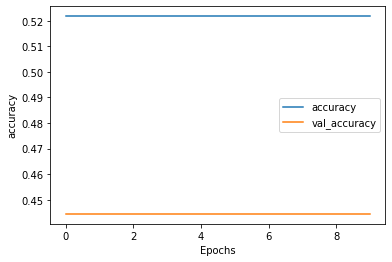

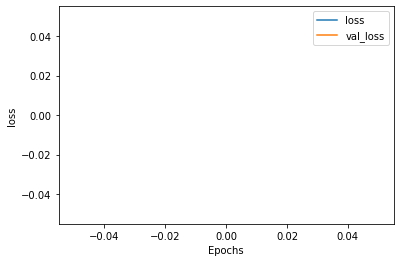

In [166]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# C3W3-5-Sarcasm with 1D Convolutional Layer

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 29,489
Trainable params: 29,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4715 - accuracy: 0.7578 - val_loss: 0.4229 - val_accuracy: 0.8071
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3579 - accuracy: 0.8384 - val_loss: 0.3917 - val_accuracy: 0.8229
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3165 - accuracy: 0.8589 - val_loss: 0.3902 - val_accuracy: 0.8219
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2799 - accuracy: 0.8791 - val_loss: 0.4029 - val_accuracy: 0.8190
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2439 - accuracy: 0.8964 - val_loss: 0.4383 - val_accuracy: 0.8214
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2101 - accuracy: 0.9145 - val_loss: 0.4600 - val_accuracy: 0.8135
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1717 - accuracy: 0.9337 - val_loss: 0.5334 - val_accuracy: 0.8111
Epoch 

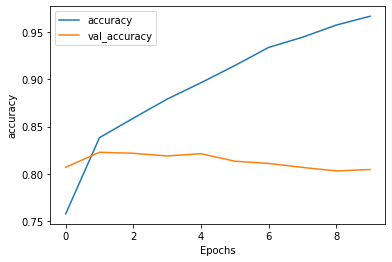

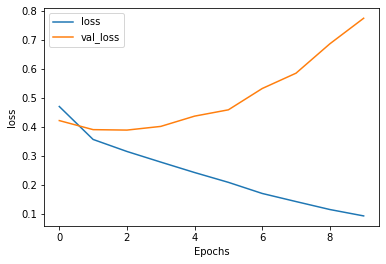

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
model.save("C3W3-5-Sarcasm_with_1D_Convolutional_Layer.h5")